In [1]:
!git clone https://github.com/duongnosu/CARE-GNN-Plus.git

Cloning into 'CARE-GNN-Plus'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 135 (delta 31), reused 23 (delta 23), pack-reused 88 (from 1)
Receiving objects: 100% (135/135), 39.97 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ls

CARE-GNN-Plus/  drive/  sample_data/


In [5]:
cd CARE-GNN-Plus/

/content/CARE-GNN-Plus


In [6]:
cd data/

/content/CARE-GNN-Plus/data


In [7]:
ls

Amazon.zip  YelpChi.zip


In [8]:
!unzip Amazon.zip

Archive:  Amazon.zip
  inflating: Amazon.mat              


In [9]:
cd ..


/content/CARE-GNN-Plus


In [10]:
!python3 data_process.py

# Vizialization

In [11]:
import numpy as np
import torch
import torch.nn as nn
from scipy.io import loadmat
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import networkx as nx
import random
from matplotlib.patches import Patch

from torch.nn import init
import torch.nn.functional as F
from torch.autograd import Variable
from operator import itemgetter
import math

# Import your existing modules
from model import OneLayerCARE
from layers import IntraAgg, InterAgg
from utils import normalize, pos_neg_split, undersample, test_care


# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)


=== Amazon Fraud Detection Dataset ===
Dataset Statistics:
Total nodes: 11944
Fraudulent users: 821 (6.87%)
Feature dimensions: (11944, 25)

Relation Statistics:
User-Product-User nodes: 11944
User-Service-User nodes: 11944
User-View-User nodes: 11944

=== Feature Preprocessing ===
✅ Features normalized and prepared
✅ Adjacency lists organized


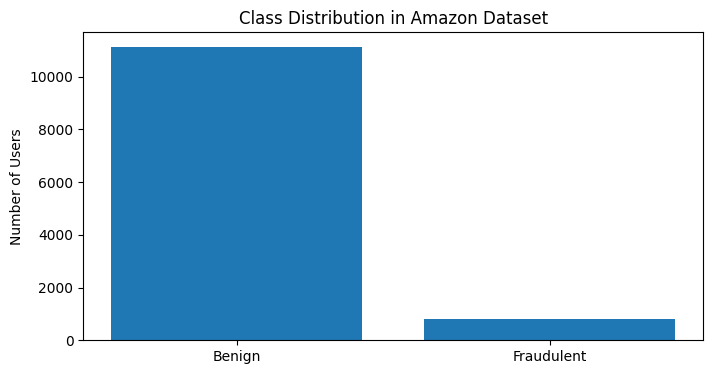

In [14]:
print("=== Amazon Fraud Detection Dataset ===")

# Load public dataset of Amazon.mat file directly
data_file = loadmat('data/Amazon.mat')
labels = data_file['label'].flatten() # Binary labels: 0=benign, 1=fraudulent
feat_data = data_file['features'].todense().A # Convert sparse matrix to dense array



# Load the preprocessed adjacency lists for different user relations
# These represent different ways users can be connected in the fraud detection graph

# User-Product-User relation: connects users who reviewed the same products
with open('data/amz_upu_adjlists.pickle', 'rb') as f:
    relation1 = pickle.load(f)  # User-Product-User

# User-Service-User relation: connects users with similar service interactions
with open('data/amz_usu_adjlists.pickle', 'rb') as f:
    relation2 = pickle.load(f)  # User-Service-User

# User-View-User relation: connects users with similar viewing/rating patterns
with open('data/amz_uvu_adjlists.pickle', 'rb') as f:
    relation3 = pickle.load(f)  # User-View-User

# Create homogeneous adjacency list (combine all relations)
homo = data_file['homo']

print(f"Dataset Statistics:")
print(f"Total nodes: {len(labels)}") # Total number of users in the dataset
print(f"Fraudulent users: {np.sum(labels == 1)} ({np.mean(labels==1)*100:.2f}%)")  # Count and percentage of fraudsters
print(f"Feature dimensions: {feat_data.shape}") # Shape of feature matrix (users x features)

print(f"\nRelation Statistics:")
print(f"User-Product-User nodes: {len(relation1)}")
print(f"User-Service-User nodes: {len(relation2)}")
print(f"User-View-User nodes: {len(relation3)}")

print(f"\n=== Feature Preprocessing ===")
# Normalize feature data to improve training stability and convergence
# This is crucial for neural networks to handle features with different scales
feat_data_normalized = normalize(feat_data)

# Create PyTorch embedding layer for efficient feature processing
# The embedding layer allows for fast lookup of user features during training
features = nn.Embedding(feat_data.shape[0], feat_data.shape[1])
features.weight = nn.Parameter(torch.FloatTensor(feat_data_normalized), requires_grad=False) # requires_grad=False because user features are fixed (not trainable parameters)

# Organize adjacency lists for multi-relation graph processing
# Each relation represents a different type of connection between users
adj_lists = [relation1, relation2, relation3]
print("✅ Features normalized and prepared")
print("✅ Adjacency lists organized")

# Visualize class distribution
plt.figure(figsize=(8, 4))
plt.bar(['Benign', 'Fraudulent'], [np.sum(labels == 0), np.sum(labels == 1)])
plt.title('Class Distribution in Amazon Dataset')
plt.ylabel('Number of Users')
plt.show()

=== Example of Graph Structure Visualization ===
Generating example UPU network visualization...

Example Ego Network (centered on fraudulent user 5755):


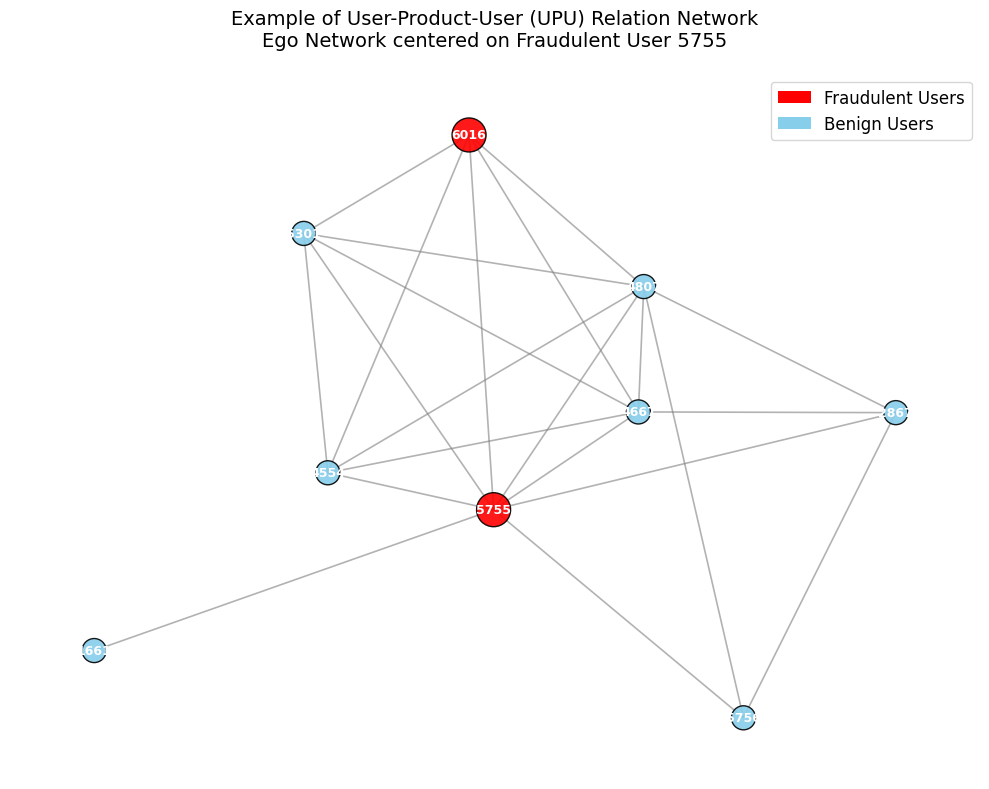

In [16]:
# =========================================================================
# Graph Structure Visualization
# =========================================================================


print("=== Example of Graph Structure Visualization ===")

# Load the User-Product-User (UPU) adjacency list data
# UPU relation connects users who have reviewed the same products
with open("data/amz_upu_adjlists.pickle", "rb") as f:
    adjlist = pickle.load(f)

# Build NetworkX graph from UPU relation
# Each node represents a user, edges connect users who reviewed same products
G = nx.Graph()
for node, neighbors in adjlist.items():
    for neighbor in neighbors:
        if node != neighbor: # To avoid self-loops
            G.add_edge(node, neighbor)

# Extract Largest Connected Component
# Focus on the main connected component where most fraud activity occurs
largest_cc = max(nx.connected_components(G), key=len)
subG = G.subgraph(largest_cc).copy()

def sample_fraud_subgraph(graph, labels, radius=1, target_size=25):
    """
    Sample a subgraph centered on a fraudulent user for visualization.

    Purpose: Create a manageable visualization that shows fraud patterns
    Strategy:
    - Start with a fraudulent user as center (ego node)
    - Include their neighborhood to show fraud clustering
    - Limit size for clear visualization

    Args:
        graph: NetworkX graph to sample from
        labels: Dictionary mapping node_id -> label (0=benign, 1=fraud)
        radius: How many hops to include (1=direct neighbors only)
        target_size: Maximum nodes to include for clear visualization

    Returns:
        ego_node: The center fraudulent user
        ego_subG: Sampled subgraph around the center user
    """
    # Find all fraudulent users in the graph
    fraud_nodes = [node for node in graph.nodes() if labels[node]==1]

    # Filter to fraud nodes with reasonable connectivity (5-30 connections)
    # Too few connections = isolated, too many = visualization becomes messy
    filtered_fraud_nodes = [n for n in fraud_nodes if 5 <= graph.degree(n) <= 30]

    # Fallback to any fraud node if filtering removes all candidates
    if not filtered_fraud_nodes:
        filtered_fraud_nodes = fraud_nodes

    # Randomly select a fraud node as the center for ego network analysis
    ego_node = random.choice(filtered_fraud_nodes)

    # Create ego graph: center node + all neighbors within 'radius' hops
    # This shows local fraud patterns and how fraudsters connect to others
    ego_subG = nx.ego_graph(graph, ego_node, radius=radius)

    # Limit size for clear visualization
    # If too many nodes, randomly sample while keeping the structure meaningful
    if ego_subG.number_of_nodes() > target_size:
        sampled_nodes = random.sample(list(ego_subG.nodes()), target_size)
        ego_subG = ego_subG.subgraph(sampled_nodes).copy()

    return ego_node, ego_subG

def visualize_fraud_subgraph(subgraph, labels, ego_node):
    """
    Create a visual representation of the fraud network structure.

    Purpose: Show how fraudulent and benign users are connected
    Key insights this reveals:
    - Fraud clustering patterns (red nodes grouped together)
    - Mixed fraud-benign connections (heterophilic edges)
    - Network density that justifies GCN aggregation

    Color scheme:
    - Red: Fraudulent users (the targets we want to detect)
    - Sky blue: Benign/legitimate users
    - Larger nodes: Fraudulent users (emphasis on fraud patterns)
    """

    # Red = fraudulent (what we want to detect)
    # Sky blue = benign/legitimate users
    colors = ['red' if labels[node]==1 else 'skyblue' for node in subgraph.nodes()]

    # Size nodes based on fraud labels
    # Larger fraud nodes help visualize fraud clustering patterns
    sizes = [600 if labels[node]==1 else 300 for node in subgraph.nodes()]

    plt.figure(figsize=(10, 8))

    # k=1.5 provides good spacing, seed=42 for reproducible layouts
    pos = nx.spring_layout(subgraph, seed=42, k=1.5)

    # Draw edges and nodes
    nx.draw_networkx_edges(subgraph, pos, edge_color='grey', alpha=0.6, width=1.2)
    nx.draw_networkx_nodes(subgraph, pos, node_color=colors, node_size=sizes,
                          alpha=0.9, edgecolors='black', linewidths=1)

    # Draw node IDs
    for node, (x, y) in pos.items():
        plt.text(x, y, str(node), fontsize=9, ha='center', va='center',
                color='white', weight='bold')

    # Legend
    legend_elements = [
        Patch(facecolor='red', label='Fraudulent Users'),
        Patch(facecolor='skyblue', label='Benign Users')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

    plt.title(f'Example of User-Product-User (UPU) Relation Network\n'
              f'Ego Network centered on Fraudulent User {ego_node}',
              fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate visualization
print("Generating example UPU network visualization...")
ego_node, small_subG = sample_fraud_subgraph(subG, labels, radius=1, target_size=20)
print(f"\nExample Ego Network (centered on fraudulent user {ego_node}):")
visualize_fraud_subgraph(small_subG, labels, ego_node)

# Paper Implementation CARE-GNN

In [17]:
# =========================================================================
# CARE-GNN Model Architecture Setup
# =========================================================================
# Purpose: Configure and initialize the complete CARE-GNN model architecture
# This section builds the multi-relation graph neural network with adaptive
# neighbor filtering for fraud detection on Amazon dataset
# =========================================================================

print("=== CARE-GNN Architecture ===")

# Core Architecture Parameters
embed_dim = 64      # Output embedding dimension for node representations
                    # - Controls model capacity and representation richness
                    # - 64 dims balance expressiveness vs computational efficiency
                    # - Sufficient for capturing fraud patterns in Amazon dataset

# Reinforcement Learning Parameters
step_size = 0.02    # RL action step size for adaptive threshold learning
                    # - Controls how quickly thresholds adapt during training
                    # - Smaller values = more stable but slower convergence
                    # - 0.02 provides good balance for fraud detection tasks (from the repo.)

# Loss Function Parameters
lambda_1 = 2.0      # Weight for similarity loss in combined objective
                    # - Balances GNN loss vs label-aware similarity loss
                    # - lambda_1 > 1 emphasizes similarity learning (good for camouflaged fraud)
                    # - Higher values help detect fraudsters who mimic legitimate behavior

# Training Parameters
batch_size = 256    # Number of nodes processed per training batch
                    # - Balances memory usage vs gradient quality
                    # - Larger batches = more stable gradients but higher memory
                    # - 256 is optimal for most fraud detection datasets

print(f"Model Configuration:")
print(f"- Embedding dimension: {embed_dim}")
print(f"- RL step size: {step_size}")
print(f"- Similarity loss weight: {lambda_1}")
print(f"- Batch size: {batch_size}")

# Build CARE-GNN model , which follow the main githup repo https://github.com/YingtongDou/CARE-GNN
intra1 = IntraAgg(features, feat_data.shape[1], cuda=False)
intra2 = IntraAgg(features, feat_data.shape[1], cuda=False)
intra3 = IntraAgg(features, feat_data.shape[1], cuda=False)

inter = InterAgg(features, feat_data.shape[1], embed_dim, adj_lists,
                 [intra1, intra2, intra3], inter='GNN', step_size=step_size, cuda=False)

model = OneLayerCARE(num_classes=2, inter1=inter, lambda_1=lambda_1)

print(f"✅ CARE-GNN model built successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

=== CARE-GNN Architecture ===
Model Configuration:
- Embedding dimension: 64
- RL step size: 0.02
- Similarity loss weight: 2.0
- Batch size: 256
✅ CARE-GNN model built successfully!
Total parameters: 300,700


# Proposed CARE-GNN-Plus

### Inter Relation Aggregator using GNN



In [18]:
class InterAgg_leaky(nn.Module):

	def __init__(self, features, feature_dim,
				 embed_dim, adj_lists, intraggs,
				 inter='GNN', step_size=0.02, cuda=True):
		"""
		Initialize the inter-relation aggregator
		:param features: the input node features or embeddings for all nodes
		:param feature_dim: the input dimension
		:param embed_dim: the output dimension
		:param adj_lists: a list of adjacency lists for each single-relation graph
		:param intraggs: the intra-relation aggregators used by each single-relation graph
		:param inter: the aggregator type: 'Att', 'Weight', 'Mean', 'GNN'
		:param step_size: the RL action step size
		:param cuda: whether to use GPU
		"""
		super(InterAgg_leaky, self).__init__()

		self.features = features
		self.dropout = 0.6
		self.adj_lists = adj_lists
		self.intra_agg1 = intraggs[0]
		self.intra_agg2 = intraggs[1]
		self.intra_agg3 = intraggs[2]
		self.embed_dim = embed_dim
		self.feat_dim = feature_dim
		self.inter = inter
		self.step_size = step_size
		self.cuda = cuda
		self.intra_agg1.cuda = cuda
		self.intra_agg2.cuda = cuda
		self.intra_agg3.cuda = cuda

		# RL condition flag
		self.RL = True

		# number of batches for current epoch, assigned during training
		self.batch_num = 0

		# initial filtering thresholds
		self.thresholds = [0.5, 0.5, 0.5]

		# the activation function used by attention mechanism
		self.leakyrelu = nn.LeakyReLU(0.2)

		# parameter used to transform node embeddings before inter-relation aggregation
		self.weight = nn.Parameter(torch.FloatTensor(self.feat_dim, self.embed_dim))
		init.xavier_uniform_(self.weight)

		# weight parameter for each relation used by CARE-Weight
		self.alpha = nn.Parameter(torch.FloatTensor(self.embed_dim, 3))
		init.xavier_uniform_(self.alpha)

		# parameters used by attention layer
		self.a = nn.Parameter(torch.FloatTensor(2 * self.embed_dim, 1))
		init.xavier_uniform_(self.a)

		# label predictor for similarity measure
		self.label_clf = nn.Linear(self.feat_dim, 2)

		# initialize the parameter logs
		self.weights_log = []
		self.thresholds_log = [self.thresholds]
		self.relation_score_log = []

	def forward(self, nodes, labels, train_flag=True):
		"""
		:param nodes: a list of batch node ids
		:param labels: a list of batch node labels, only used by the RLModule
		:param train_flag: indicates whether in training or testing mode
		:return combined: the embeddings of a batch of input node features
		:return center_scores: the label-aware scores of batch nodes
		"""

		# extract 1-hop neighbor ids from adj lists of each single-relation graph
		to_neighs = []
		for adj_list in self.adj_lists:
			to_neighs.append([set(adj_list[int(node)]) for node in nodes])

		# find unique nodes and their neighbors used in current batch
		unique_nodes = set.union(set.union(*to_neighs[0]), set.union(*to_neighs[1]),
								 set.union(*to_neighs[2], set(nodes)))

		# calculate label-aware scores
		if self.cuda:
			batch_features = self.features(torch.cuda.LongTensor(list(unique_nodes)))
		else:
			batch_features = self.features(torch.LongTensor(list(unique_nodes)))
		batch_scores = self.label_clf(batch_features)
		id_mapping = {node_id: index for node_id, index in zip(unique_nodes, range(len(unique_nodes)))}

		# the label-aware scores for current batch of nodes
		center_scores = batch_scores[itemgetter(*nodes)(id_mapping), :]

		# get neighbor node id list for each batch node and relation
		r1_list = [list(to_neigh) for to_neigh in to_neighs[0]]
		r2_list = [list(to_neigh) for to_neigh in to_neighs[1]]
		r3_list = [list(to_neigh) for to_neigh in to_neighs[2]]

		# assign label-aware scores to neighbor nodes for each batch node and relation
		r1_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r1_list]
		r2_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r2_list]
		r3_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r3_list]

		# count the number of neighbors kept for aggregation for each batch node and relation
		r1_sample_num_list = [math.ceil(len(neighs) * self.thresholds[0]) for neighs in r1_list]
		r2_sample_num_list = [math.ceil(len(neighs) * self.thresholds[1]) for neighs in r2_list]
		r3_sample_num_list = [math.ceil(len(neighs) * self.thresholds[2]) for neighs in r3_list]

		# intra-aggregation steps for each relation
		# Eq. (8) in the paper
		r1_feats, r1_scores = self.intra_agg1.forward(nodes, r1_list, center_scores, r1_scores, r1_sample_num_list)
		r2_feats, r2_scores = self.intra_agg2.forward(nodes, r2_list, center_scores, r2_scores, r2_sample_num_list)
		r3_feats, r3_scores = self.intra_agg3.forward(nodes, r3_list, center_scores, r3_scores, r3_sample_num_list)

		# concat the intra-aggregated embeddings from each relation
		neigh_feats = torch.cat((r1_feats, r2_feats, r3_feats), dim=0)

		# get features or embeddings for batch nodes
		if self.cuda and isinstance(nodes, list):
			index = torch.LongTensor(nodes).cuda()
		else:
			index = torch.LongTensor(nodes)
		self_feats = self.features(index)

		# number of nodes in a batch
		n = len(nodes)

		# inter-relation aggregation steps
		# Eq. (9) in the paper
		# if self.inter == 'Att':
		# 	# 1) CARE-Att Inter-relation Aggregator
		# 	combined, attention = att_inter_agg(len(self.adj_lists), self.leakyrelu, self_feats, neigh_feats, self.embed_dim,
		# 										self.weight, self.a, n, self.dropout, self.training, self.cuda)
		# elif self.inter == 'Weight':
		# 	# 2) CARE-Weight Inter-relation Aggregator
		# 	combined = weight_inter_agg(len(self.adj_lists), self_feats, neigh_feats, self.embed_dim, self.weight, self.alpha, n, self.cuda)
		# 	gem_weights = F.softmax(torch.sum(self.alpha, dim=0), dim=0).tolist()
		# 	if train_flag:
		# 		print(f'Weights: {gem_weights}')
		# elif self.inter == 'Mean':
		# 	# 3) CARE-Mean Inter-relation Aggregator
		# 	combined = mean_inter_agg(len(self.adj_lists), self_feats, neigh_feats, self.embed_dim, self.weight, n, self.cuda)
		if self.inter == 'GNN':
			# 4) CARE-GNN Inter-relation Aggregator
			combined = threshold_inter_agg(len(self.adj_lists), self_feats, neigh_feats, self.embed_dim, self.weight, self.thresholds, n, self.cuda)

		# the reinforcement learning module
		if self.RL and train_flag:
			relation_scores, rewards, thresholds, stop_flag = RLModule([r1_scores, r2_scores, r3_scores],
																	   self.relation_score_log, labels, self.thresholds,
																	   self.batch_num, self.step_size)
			self.thresholds = thresholds
			self.RL = stop_flag
			self.relation_score_log.append(relation_scores)
			self.thresholds_log.append(self.thresholds)

		return combined, center_scores

### Instra Relation Aggregator with LeakyReLU (Proposed)



In [19]:
class IntraAgg_leaky(nn.Module):

	def __init__(self, features, feat_dim, cuda=False):
		"""
		Initialize the intra-relation aggregator
		:param features: the input node features or embeddings for all nodes
		:param feat_dim: the input dimension
		:param cuda: whether to use GPU
		"""
		super(IntraAgg_leaky, self).__init__()

		self.features = features
		self.cuda = cuda
		self.feat_dim = feat_dim

	def forward(self, nodes, to_neighs_list, batch_scores, neigh_scores, sample_list):
		"""
		Code partially from https://github.com/williamleif/graphsage-simple/
		:param nodes: list of nodes in a batch
		:param to_neighs_list: neighbor node id list for each batch node in one relation
		:param batch_scores: the label-aware scores of batch nodes
		:param neigh_scores: the label-aware scores 1-hop neighbors each batch node in one relation
		:param sample_list: the number of neighbors kept for each batch node in one relation
		:return to_feats: the aggregated embeddings of batch nodes neighbors in one relation
		:return samp_scores: the average neighbor distances for each relation after filtering
		"""

		# filer neighbors under given relation
		samp_neighs, samp_scores = filter_neighs_ada_threshold(batch_scores, neigh_scores, to_neighs_list, sample_list)

		# find the unique nodes among batch nodes and the filtered neighbors
		unique_nodes_list = list(set.union(*samp_neighs))
		unique_nodes = {n: i for i, n in enumerate(unique_nodes_list)}

		# intra-relation aggregation only with sampled neighbors
		mask = Variable(torch.zeros(len(samp_neighs), len(unique_nodes)))
		column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]
		row_indices = [i for i in range(len(samp_neighs)) for _ in range(len(samp_neighs[i]))]
		mask[row_indices, column_indices] = 1
		if self.cuda:
			mask = mask.cuda()
		num_neigh = mask.sum(1, keepdim=True)
		mask = mask.div(num_neigh)
		if self.cuda:
			embed_matrix = self.features(torch.LongTensor(unique_nodes_list).cuda())
		else:
			embed_matrix = self.features(torch.LongTensor(unique_nodes_list))
		to_feats = mask.mm(embed_matrix)
		# to_feats = F.relu(to_feats)
		to_feats = nn.LeakyReLU(0.2)(to_feats) # Proposed Leakly Relu Activtion eqn 8
		return to_feats, samp_scores


### Reinforcement Learning Module

In [20]:
def RLModule(scores, scores_log, labels, thresholds, batch_num, step_size):
	"""
	The reinforcement learning module.
	It updates the neighbor filtering threshold for each relation based
	on the average neighbor distances between two consecutive epochs.
	:param scores: the neighbor nodes label-aware scores for each relation
	:param scores_log: a list stores the relation average distances for each batch
	:param labels: the batch node labels used to select positive nodes
	:param thresholds: the current neighbor filtering thresholds for each relation
	:param batch_num: numbers batches in an epoch
	:param step_size: the RL action step size
	:return relation_scores: the relation average distances for current batch
	:return rewards: the reward for given thresholds in current epoch
	:return new_thresholds: the new filtering thresholds updated according to the rewards
	:return stop_flag: the RL terminal condition flag
	"""

	relation_scores = []
	stop_flag = True

	# only compute the average neighbor distances for positive nodes
	pos_index = (labels == 1).nonzero().tolist()
	pos_index = [i[0] for i in pos_index]

	# compute average neighbor distances for each relation
	for score in scores:
		pos_scores = itemgetter(*pos_index)(score)
		neigh_count = sum([1 if isinstance(i, float) else len(i) for i in pos_scores])
		pos_sum = [i if isinstance(i, float) else sum(i) for i in pos_scores]
		relation_scores.append(sum(pos_sum) / neigh_count)

	if len(scores_log) % batch_num != 0 or len(scores_log) < 2 * batch_num:
		# do not call RL module within the epoch or within the first two epochs
		rewards = [0, 0, 0]
		new_thresholds = thresholds
	else:
		# update thresholds according to average scores in last epoch
		# Eq.(5) in the paper
		previous_epoch_scores = [sum(s) / batch_num for s in zip(*scores_log[-2 * batch_num:-batch_num])]
		current_epoch_scores = [sum(s) / batch_num for s in zip(*scores_log[-batch_num:])]

		# compute reward for each relation and update the thresholds according to reward
		# Eq. (6) in the paper
		rewards = [1 if previous_epoch_scores[i] - s >= 0 else -1 for i, s in enumerate(current_epoch_scores)]
		new_thresholds = [thresholds[i] + step_size if r == 1 else thresholds[i] - step_size for i, r in enumerate(rewards)]

		# avoid overflow
		new_thresholds = [0.999 if i > 1 else i for i in new_thresholds]
		new_thresholds = [0.001 if i < 0 else i for i in new_thresholds]

		print(f'epoch scores: {current_epoch_scores}')
		print(f'rewards: {rewards}')
		print(f'thresholds: {new_thresholds}')

	return relation_scores, rewards, new_thresholds, stop_flag

### Filter neighbors from label predictor

In [21]:
def filter_neighs_ada_threshold(center_scores, neigh_scores, neighs_list, sample_list):
	"""
	Filter neighbors according label predictor result with adaptive thresholds
	:param center_scores: the label-aware scores of batch nodes
	:param neigh_scores: the label-aware scores 1-hop neighbors each batch node in one relation
	:param neighs_list: neighbor node id list for each batch node in one relation
	:param sample_list: the number of neighbors kept for each batch node in one relation
	:return samp_neighs: the neighbor indices and neighbor simi scores
	:return samp_scores: the average neighbor distances for each relation after filtering
	"""

	samp_neighs = []
	samp_scores = []
	for idx, center_score in enumerate(center_scores):
		center_score = center_scores[idx][0]
		neigh_score = neigh_scores[idx][:, 0].view(-1, 1)
		center_score = center_score.repeat(neigh_score.size()[0], 1)
		neighs_indices = neighs_list[idx]
		num_sample = sample_list[idx]

		# compute the L1-distance of batch nodes and their neighbors
		# Eq. (2) in paper
		score_diff = torch.abs(center_score - neigh_score).squeeze()
		sorted_scores, sorted_indices = torch.sort(score_diff, dim=0, descending=False)
		selected_indices = sorted_indices.tolist()

		# top-p sampling according to distance ranking and thresholds
		# Section 3.3.1 in paper
		if len(neigh_scores[idx]) > num_sample + 1:
			selected_neighs = [neighs_indices[n] for n in selected_indices[:num_sample]]
			selected_scores = sorted_scores.tolist()[:num_sample]
		else:
			selected_neighs = neighs_indices
			selected_scores = score_diff.tolist()
			if isinstance(selected_scores, float):
				selected_scores = [selected_scores]

		samp_neighs.append(set(selected_neighs))
		samp_scores.append(selected_scores)

	return samp_neighs, samp_scores

### CARE-GNN-Plus inter-relation aggregator using LeakyReLU (Proposed)

In [22]:
def threshold_inter_agg(num_relations, self_feats, neigh_feats, embed_dim, weight, threshold, n, cuda):
	"""
	CARE-GNN inter-relation aggregator
	Eq. (9) in the paper use Leaky Relu instread of Relu
	:param num_relations: number of relations in the graph
	:param self_feats: batch nodes features or embeddings
	:param neigh_feats: intra-relation aggregated neighbor embeddings for each relation
	:param embed_dim: the dimension of output embedding
	:param weight: parameter used to transform node embeddings before inter-relation aggregation
	:param threshold: the neighbor filtering thresholds used as aggregating weights
	:param n: number of nodes in a batch
	:param cuda: whether use GPU
	:return: inter-relation aggregated node embeddings
	"""

	# transform batch node embedding and neighbor embedding in each relation with weight parameter
	center_h = torch.mm(self_feats, weight)
	neigh_h = torch.mm(neigh_feats, weight)

	# initialize the final neighbor embedding
	if cuda:
		aggregated = torch.zeros(size=(n, embed_dim)).cuda()
	else:
		aggregated = torch.zeros(size=(n, embed_dim))

	# add weighted neighbor embeddings in each relation together
	for r in range(num_relations):
		aggregated += neigh_h[r * n:(r + 1) * n, :] * threshold[r]

	# sum aggregated neighbor embedding and batch node embedding
	# feed them to activation function
	# combined = F.relu(center_h + aggregated)
	combined = nn.LeakyReLU(0.2)(center_h + aggregated) # Proposed Leakly Relu Activtion eqn 9

	return combined

## CARE-GNN-Plus Model Architecture

In [23]:
class MultiLayerCARE_Leaky(nn.Module):
    """
    Multi-Layer CARE-GNN- with additional transform layers and residual connections between embeddings
    """
    def __init__(self, num_classes, features, feat_dim, embed_dim, adj_lists,
                 num_layers=2, lambda_1=2.0, step_size=0.02, cuda=False):
        super(MultiLayerCARE_Leaky, self).__init__()

        self.num_layers = num_layers
        self.lambda_1 = lambda_1
        self.xent = nn.CrossEntropyLoss()

        # Core CARE-GNN components
        intra1 = IntraAgg_leaky(features, feat_dim, cuda=cuda)
        intra2 = IntraAgg_leaky(features, feat_dim, cuda=cuda)
        intra3 = IntraAgg_leaky(features, feat_dim, cuda=cuda)

        self.inter1 = InterAgg_leaky(features, feat_dim, embed_dim, adj_lists,
                              [intra1, intra2, intra3],
                              inter='GNN', step_size=step_size, cuda=cuda)

        # Disable RL to prevent modulo by zero error
        self.inter1.RL = False

        ##### NOVELTY PROPOSED #####
        # Novelty: Add additional transformation layers

        self.transforms = nn.ModuleList()
        for i in range(num_layers - 1):
            self.transforms.append(nn.Linear(embed_dim, embed_dim))
        #############################
        # Final classifier
        self.weight = nn.Parameter(torch.FloatTensor(embed_dim, num_classes))
        init.xavier_uniform_(self.weight)

    def forward(self, nodes, labels, train_flag=True):
        # First layer (CARE-GNN without RL issues)
        embeddings, label_scores = self.inter1(nodes, labels, train_flag)

        # NOVELTY: Apply additional transformations
        #applies a sequence of linear layers with ReLU, followed by residual connections (like in ResNet):
        prev_embeddings = embeddings
        for i, transform in enumerate(self.transforms):
            embeddings = F.relu(transform(embeddings))
            # ALSOAdd residual connection for deeper layers
            if i > 0:
                embeddings = embeddings + prev_embeddings
            prev_embeddings = embeddings
        ##################################################
        # Final prediction
        scores = torch.mm(embeddings, self.weight)
        return scores, label_scores

    def to_prob(self, nodes, labels, train_flag=True):
        gnn_scores, label_scores = self.forward(nodes, labels, train_flag)
        gnn_prob = nn.functional.softmax(gnn_scores, dim=1)
        label_prob = nn.functional.softmax(label_scores, dim=1)
        return gnn_prob, label_prob

    def loss(self, nodes, labels, train_flag=True):
        gnn_scores, label_scores = self.forward(nodes, labels, train_flag)

        # GNN loss
        gnn_loss = self.xent(gnn_scores, labels.squeeze())

        # Similarity loss (same as baseline)
        label_loss = self.xent(label_scores, labels.squeeze())

        # Combined loss
        final_loss = gnn_loss + self.lambda_1 * label_loss
        return final_loss


# Experiment

### CARE-GNN Base Model ( paper)

In [25]:
# =========================================================================
# CARE-GNN Model Architecture Setup
# =========================================================================
# Purpose: Configure and initialize the complete CARE-GNN model architecture
# This section builds the multi-relation graph neural network with adaptive
# neighbor filtering for fraud detection on Amazon dataset
# =========================================================================

print("=== CARE-GNN Architecture ===")

# Core Architecture Parameters
embed_dim = 64      # Output embedding dimension for node representations
                    # - Controls model capacity and representation richness
                    # - 64 dims balance expressiveness vs computational efficiency
                    # - Sufficient for capturing fraud patterns in Amazon dataset

# Reinforcement Learning Parameters
step_size = 0.02    # RL action step size for adaptive threshold learning
                    # - Controls how quickly thresholds adapt during training
                    # - Smaller values = more stable but slower convergence
                    # - 0.02 provides good balance for fraud detection tasks (from the repo.)

# Loss Function Parameters
lambda_1 = 2.0      # Weight for similarity loss in combined objective
                    # - Balances GNN loss vs label-aware similarity loss
                    # - lambda_1 > 1 emphasizes similarity learning (good for camouflaged fraud)
                    # - Higher values help detect fraudsters who mimic legitimate behavior

# Training Parameters
batch_size = 256    # Number of nodes processed per training batch
                    # - Balances memory usage vs gradient quality
                    # - Larger batches = more stable gradients but higher memory
                    # - 256 is optimal for most fraud detection datasets

print(f"Model Configuration:")
print(f"- Embedding dimension: {embed_dim}")
print(f"- RL step size: {step_size}")
print(f"- Similarity loss weight: {lambda_1}")
print(f"- Batch size: {batch_size}")

# Build CARE-GNN model , which follow the main githup repo https://github.com/YingtongDou/CARE-GNN
intra1 = IntraAgg(features, feat_data.shape[1], cuda=False)
intra2 = IntraAgg(features, feat_data.shape[1], cuda=False)
intra3 = IntraAgg(features, feat_data.shape[1], cuda=False)

inter = InterAgg(features, feat_data.shape[1], embed_dim, adj_lists,
                 [intra1, intra2, intra3], inter='GNN', step_size=step_size, cuda=False)

model = OneLayerCARE(num_classes=2, inter1=inter, lambda_1=lambda_1)

print(f"✅ CARE-GNN model built successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

=== CARE-GNN Architecture ===
Model Configuration:
- Embedding dimension: 64
- RL step size: 0.02
- Similarity loss weight: 2.0
- Batch size: 256
✅ CARE-GNN model built successfully!
Total parameters: 300,700


### Proposed Multi-Layer CARE-GNN-Plus with LeakyReLU and residual connections between embedding layers

In [26]:
# 2 layer or neural network
model2_leaky = MultiLayerCARE_Leaky(
    num_classes=2,
    features=features,
    feat_dim=feat_data.shape[1],
    embed_dim=embed_dim,
    adj_lists=adj_lists,
    num_layers=2,
    lambda_1=lambda_1,
    step_size=step_size,
    cuda=False
)

In [27]:
print(type(model2_leaky))

<class '__main__.MultiLayerCARE_Leaky'>


In [28]:
# 3 layers of neural network
model3_leaky = MultiLayerCARE_Leaky(
    num_classes=2,
    features=features,
    feat_dim=feat_data.shape[1],
    embed_dim=embed_dim,
    adj_lists=adj_lists,
    num_layers=3, # 3 layers
    lambda_1=lambda_1,
    step_size=step_size,
    cuda=False
)

### Ultils Functions for training and evaluation

In [29]:
def train_care_model(model, model_name, train_pos, train_neg, labels,
                      learning_rate=0.01, weight_decay=1e-3, momentum=0.9, num_epochs=15,
                      batch_size=256, scale=1, verbose=True, plot_loss=True):
    """
    General training function for CARE-GNN models (including multi-layer variants)

    Args:
        model: The CARE model to train (model2_leaky, model3_leaky, etc.)
        model_name: String name for the model (for logging and plotting)
        train_pos: List of positive training sample indices
        train_neg: List of negative training sample indices
        labels: Array of all node labels
        learning_rate: Learning rate for SGD optimizer
        weight_decay: Weight decay for SGD optimizer
        momentum: Momentum for SGD optimizer
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        scale: Scale factor for undersampling (1 means balanced)
        verbose: Whether to print training progress
        plot_loss: Whether to plot training loss curve

    Returns:
        train_losses: List of training losses per epoch
        trained_model: The trained model
    """

    if verbose:
        print(f"=== Training {model_name} ===")

    # Setup SGD optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                               weight_decay=weight_decay, momentum=momentum)

    # Track losses
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()

        # Undersample negative samples for balanced training
        sampled_idx_train = undersample(train_pos, train_neg, scale=scale)
        random.shuffle(sampled_idx_train)

        # Calculate number of batches
        num_batches = (len(sampled_idx_train) + batch_size - 1) // batch_size

        # Set batch number for RL module (if model has inter1 with RL)
        if hasattr(model, 'inter1') and hasattr(model.inter1, 'batch_num'):
            model.inter1.batch_num = num_batches

        epoch_loss = 0.0

        # Batch training
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(sampled_idx_train))
            batch_nodes = sampled_idx_train[start_idx:end_idx]
            batch_labels = torch.LongTensor(labels[batch_nodes])

            optimizer.zero_grad()

            # Forward pass
            loss = model.loss(batch_nodes, batch_labels, train_flag=True)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate average loss for epoch
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)

        # Print progress
        if verbose and epoch % 3 == 0:
            print(f"Epoch {epoch:2d}: Loss = {avg_loss:.4f}")

    if verbose:
        print(f"✅ {model_name} training completed!")

    # Plot training loss
    if plot_loss:
        plt.figure(figsize=(8, 4))
        plt.plot(train_losses, label=model_name)
        plt.title(f'{model_name} Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    return train_losses, model

# Train Model

## CARE-GNN Original Paper with Adam Optimizer


In [30]:
# =========================================================================
# Training Configuration and Data Preparation
# =========================================================================
# Purpose: Set up training/testing data splits and configure optimization
# This section handles the unique characteristics of fraud detection datasets:
# - Class imbalance (few fraudulent vs many benign users)
# - Semi-supervised setting (unlabeled nodes in graph)
# - Stratified sampling to maintain fraud ratio across splits
# =========================================================================


## Training Setup

print("=== Training Configuration ===")

# =========================================================================
# Amazon Dataset Split Strategy
# =========================================================================
# Amazon fraud detection dataset has a unique structure:
# - First 3305 nodes are UNLABELED (used for inductive learning)
# - Remaining nodes have ground truth labels for training/testing
# This semi-supervised setup reflects real-world fraud detection scenarios

# Extract labeled portion of the dataset
# Skip first 3305 unlabeled nodes and work with labeled subset

labeled_indices = list(range(3305, len(labels)))
labeled_labels = labels[3305:]

# =========================================================================
# Stratified Train/Test Split
# =========================================================================
# Use stratified sampling to maintain fraud ratio in both splits
# Critical for fraud detection where class imbalance is severe
idx_train, idx_test, y_train, y_test = train_test_split(
    labeled_indices, labeled_labels,
    stratify=labeled_labels,
    test_size=0.6,  # 60% for testing, 40% for training
    random_state=42
)

# Split rationale for fraud detection:
# - test_size=0.6: Following standard fraud detection evaluation protocol
# - 40% training / 60% testing split is common in fraud detection literature
# - Large test set ensures robust evaluation on imbalanced fraud data
# - Stratify preserves fraud/benign ratio in both train/test splits
# - This split ratio aligns with CARE-GNN experimental setup

print(f"Training samples: {len(idx_train)}")
print(f"Test samples: {len(idx_test)}")

# Split positive and negative samples for undersampling
train_pos, train_neg = pos_neg_split(idx_train, y_train)
print(f"Training - Positive: {len(train_pos)}, Negative: {len(train_neg)}")

# Training setup from the article
learning_rate = 0.01
weight_decay = 1e-3
num_epochs = 15

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(f"✅ Training setup complete!")

=== Training Configuration ===
Training samples: 3455
Test samples: 5184
Training - Positive: 328, Negative: 3127
✅ Training setup complete!


=== Training CARE-GNN ===
epoch scores: [0.1149667104688153, 0.10075295031565525, 0.08722528578161885]
rewards: [1, -1, 1]
thresholds: [0.2599999999999998, 0.2199999999999998, 0.33999999999999986]
Epoch  0: Loss = 1.4190
epoch scores: [0.1310028312625758, 0.10471147902975843, 0.0980159253550585]
rewards: [-1, -1, -1]
thresholds: [0.2399999999999998, 0.19999999999999982, 0.31999999999999984]
epoch scores: [0.1321420171297443, 0.09642400940382567, 0.0984514697797469]
rewards: [-1, 1, -1]
thresholds: [0.2199999999999998, 0.2199999999999998, 0.2999999999999998]
epoch scores: [0.1295909861732191, 0.10842877388283338, 0.08924049333876723]
rewards: [1, -1, 1]
thresholds: [0.2399999999999998, 0.19999999999999982, 0.31999999999999984]
Epoch  3: Loss = 1.3900
epoch scores: [0.13662813451032785, 0.11062960382359432, 0.09406194590031196]
rewards: [-1, -1, -1]
thresholds: [0.2199999999999998, 0.17999999999999983, 0.2999999999999998]
epoch scores: [0.1443081146954104, 0.11611067432113596, 0.09246100

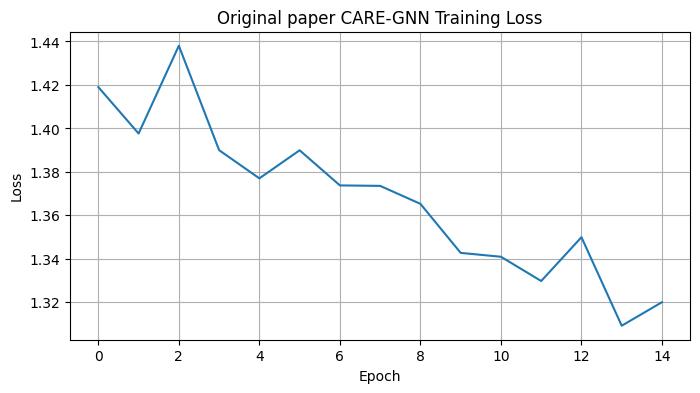

In [32]:
# =========================================================================
# CARE-GNN Model Training
# =========================================================================
# Purpose: Train the complete CARE-GNN model with adaptive neighbor filtering
# This section implements the full training loop including:
# - Class-balanced undersampling for fraud detection
# - Reinforcement learning threshold adaptation
# - Multi-relation graph neural network optimization
# - Combined loss function training (GNN + similarity)
# =========================================================================

print("=== Training CARE-GNN ===")

train_losses = []

for epoch in range(num_epochs):
    model.train()

    # =====================================================================
    # Class-Balanced Undersampling
    # =====================================================================
    # Address severe class imbalance in fraud detection
    # Critical for preventing bias toward majority class (benign users)
    sampled_idx_train = undersample(train_pos, train_neg, scale=1)
    # Randomize batch order for better gradient updates
    random.shuffle(sampled_idx_train)

    # Set batch number for RL module
    num_batches = (len(sampled_idx_train) + batch_size - 1) // batch_size
    inter.batch_num = num_batches

    epoch_loss = 0.0


    # =====================================================================
    # Mini-Batch Training Loop
    # =====================================================================
    # Process training data in batches for memory efficiency
    # Essential for large fraud detection graphs

    for batch_idx in range(num_batches):
        # Extract batch of nodes to process
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(sampled_idx_train))
        batch_nodes = sampled_idx_train[start_idx:end_idx]

        # Get corresponding labels for supervision
        batch_labels = torch.LongTensor(labels[batch_nodes])

        # Reset gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass
        # This includes:
        # 1. Multi-relation neighbor extraction (UPU, USU, UVU)
        # 2. Label-aware similarity computation
        # 3. Adaptive neighbor filtering (using current RL thresholds)
        # 4. Intra-relation aggregation for each relation
        # 5. Inter-relation aggregation (CARE-GNN method)
        # 6. Final classification and similarity loss computation
        loss = model.loss(batch_nodes, batch_labels, train_flag=True)

        # Backward pass
        # This updates:
        # - GNN aggregation weights
        # - Inter-relation combination parameters
        # - Final classification layer weights
        # - Label-aware similarity predictor weights
        # Note: RL thresholds are updated separately in the RL module
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)

    if epoch % 3 == 0:
        print(f"Epoch {epoch:2d}: Loss = {avg_loss:.4f}")

print("✅ Training completed!")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.title('Original paper CARE-GNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


## Train Proposed Model (CARE-GNN_Plus) with SGD Optimizer

=== Training Multi-Layer CARE-GNN Plus (2 layers + LeakyReLU) ===
Epoch  0: Loss = 1.6711
Epoch  3: Loss = 1.5960
Epoch  6: Loss = 1.5868
Epoch  9: Loss = 1.5723
Epoch 12: Loss = 1.5117
✅ Multi-Layer CARE-GNN Plus (2 layers + LeakyReLU) training completed!


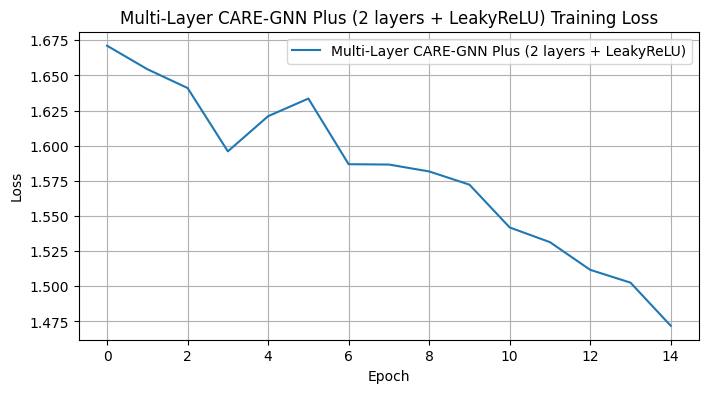

=== Training Multi-Layer CARE-GNN-Plus (3 layers + LeakyReLU) ===
Epoch  0: Loss = 1.7388
Epoch  3: Loss = 1.7099
Epoch  6: Loss = 1.5928
Epoch  9: Loss = 1.6042
Epoch 12: Loss = 1.5513
✅ Multi-Layer CARE-GNN-Plus (3 layers + LeakyReLU) training completed!


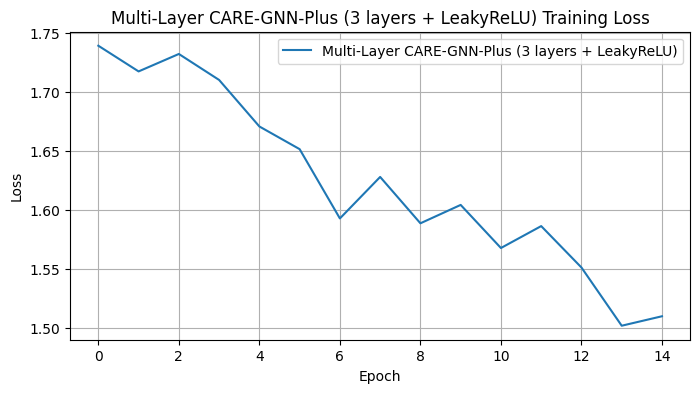

In [38]:
# Train 2-layer model with SGD
losses_2layer, trained_model2 = train_care_model(
    model=model2_leaky,
    model_name="Multi-Layer CARE-GNN Plus (2 layers + LeakyReLU)",
    train_pos=train_pos,
    train_neg=train_neg,
    labels=labels,
    learning_rate=0.01,
    weight_decay=1e-3,
    momentum=0.9,        # SGD momentum
    num_epochs=15,
    batch_size=256
)

# Train 3-layer model with SGD
losses_3layer, trained_model3 = train_care_model(
    model=model3_leaky,
    model_name="Multi-Layer CARE-GNN-Plus (3 layers + LeakyReLU)",
    train_pos=train_pos,
    train_neg=train_neg,
    labels=labels,
    learning_rate=0.01,
    weight_decay=1e-3,
    momentum=0.9,        # SGD momentum
    num_epochs=15,
    batch_size=256
)

In [43]:
losses_2layer

[1.6711314916610718,
 1.654421369234721,
 1.6410319407780964,
 1.5959758361180623,
 1.6210058530171711,
 1.6335264841715496,
 1.5868289470672607,
 1.5865929524103801,
 1.5816866159439087,
 1.5722882747650146,
 1.541838010152181,
 1.5313790241877239,
 1.5116862853368123,
 1.502577821413676,
 1.4719191789627075]

=== Training Original CARE-GNN with SGD Optimizer ===
epoch scores: [0.1706813326415895, 0.15534162982821095, 0.10968576921232766]
rewards: [-1, 1, -1]
thresholds: [0.15999999999999984, 0.15999999999999984, 0.2399999999999998]
Epoch  0: Loss = 1.2686
epoch scores: [0.1632391727028676, 0.1649756819904248, 0.11499618497621127]
rewards: [1, -1, -1]
thresholds: [0.17999999999999983, 0.13999999999999985, 0.2199999999999998]
epoch scores: [0.17398854467558578, 0.17493964129861814, 0.1059139076403753]
rewards: [-1, -1, 1]
thresholds: [0.15999999999999984, 0.11999999999999984, 0.2399999999999998]
epoch scores: [0.16862652028882227, 0.15340923894959582, 0.10144715367270236]
rewards: [1, 1, 1]
thresholds: [0.17999999999999983, 0.13999999999999985, 0.2599999999999998]
Epoch  3: Loss = 1.3012
epoch scores: [0.17874618074092583, 0.16191353635399677, 0.11139275734145238]
rewards: [-1, -1, -1]
thresholds: [0.15999999999999984, 0.11999999999999984, 0.2399999999999998]
epoch scores: [0.1642076646241473

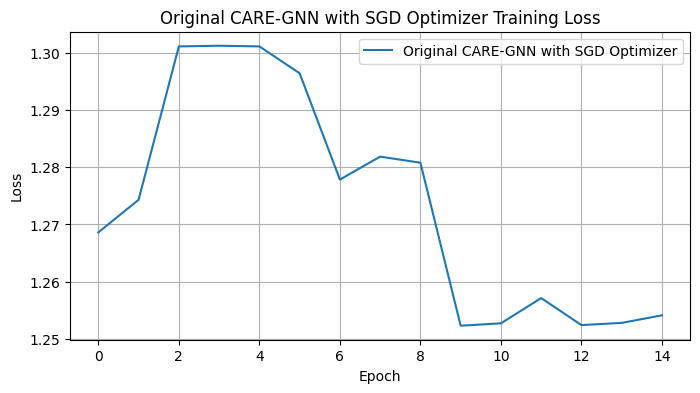

In [40]:

losses_base, trained_base = train_care_model(
    model=model,
    model_name="Original CARE-GNN with SGD Optimizer",
    train_pos=train_pos,
    train_neg=train_neg,
    labels=labels,
    learning_rate=0.01,
    weight_decay=1e-3,
    momentum=0.9,        # SGD momentum
    num_epochs=15,
    batch_size=256
)

# Models Evaluations

=== Original Paper CARE-GNN Evaluation ===
GNN F1: 0.8975
GNN Accuracy: 0.9660
GNN Recall: 0.8899
GNN auc: 0.9431
GNN ap: 0.8462
Label1 F1: 0.8113
Label1 Accuracy: 0.9230
Label1 Recall: 0.8719
Label1 auc: 0.8754
Label1 ap: 0.8022

Final Results:
Original Paper CARE-GNN Final Model:
  AUC:    0.9431
  Recall: 0.8899


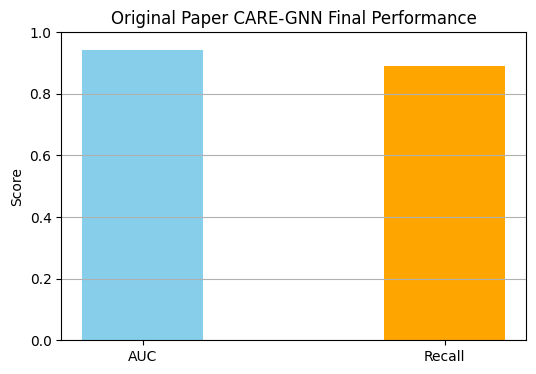

In [35]:
# === CARE-GNN Evaluation ===

print("=== Original Paper CARE-GNN Evaluation ===")

# Evaluate on test set
gnn_auc, label_auc, gnn_recall, label_recall = test_care(idx_test, y_test, model, batch_size)

print("\nFinal Results:")
print("=" * 40)
print(f"Original Paper CARE-GNN Final Model:")
print(f"  AUC:    {gnn_auc:.4f}")
print(f"  Recall: {gnn_recall:.4f}")

# Visualize final CARE-GNN performance
plt.figure(figsize=(6, 4))

metrics = ['AUC', 'Recall']
scores = [gnn_auc, gnn_recall]

x = np.arange(len(metrics))
width = 0.4

plt.bar(x, scores, width, color=['skyblue', 'orange'])
plt.xticks(x, metrics)
plt.ylim([0, 1])
plt.ylabel('Score')
plt.title('Original Paper CARE-GNN Final Performance')

plt.grid(axis='y')
plt.show()



=== 2-Layer CARE Model Evaluation ===
GNN F1: 0.8809
GNN Accuracy: 0.9593
GNN Recall: 0.8816
GNN auc: 0.8787
GNN ap: 0.8060
Label1 F1: 0.7282
Label1 Accuracy: 0.8657
Label1 Recall: 0.8410
Label1 auc: 0.8664
Label1 ap: 0.7977
2-Layer Model Results:
  AUC:    0.8787
  Recall: 0.8816

=== 3-Layer CARE Model Evaluation ===
GNN F1: 0.8902
GNN Accuracy: 0.9634
GNN Recall: 0.8822
GNN auc: 0.9177
GNN ap: 0.8171
Label1 F1: 0.6111
Label1 Accuracy: 0.7468
Label1 Recall: 0.7789
Label1 auc: 0.8651
Label1 ap: 0.7961
3-Layer Model Results:
  AUC:    0.9177
  Recall: 0.8822


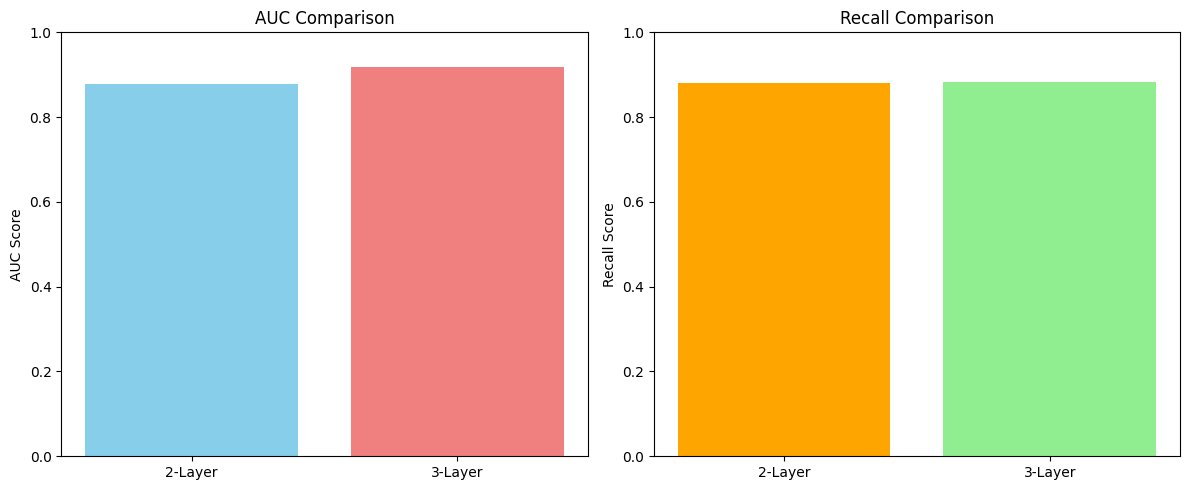

In [39]:
# Evaluate 2-layer model
print("\n=== 2-Layer CARE Model Evaluation ===")
gnn_auc_2l, label_auc_2l, gnn_recall_2l, label_recall_2l = test_care(idx_test, y_test, trained_model2, batch_size)

print(f"2-Layer Model Results:")
print(f"  AUC:    {gnn_auc_2l:.4f}")
print(f"  Recall: {gnn_recall_2l:.4f}")

# Evaluate 3-layer model
print("\n=== 3-Layer CARE Model Evaluation ===")
gnn_auc_3l, label_auc_3l, gnn_recall_3l, label_recall_3l = test_care(idx_test, y_test, trained_model3, batch_size)

print(f"3-Layer Model Results:")
print(f"  AUC:    {gnn_auc_3l:.4f}")
print(f"  Recall: {gnn_recall_3l:.4f}")

# Manual comparison plot
plt.figure(figsize=(12, 5))

# AUC comparison
plt.subplot(1, 2, 1)
models = ['2-Layer', '3-Layer']
aucs = [gnn_auc_2l, gnn_auc_3l]
plt.bar(models, aucs, color=['skyblue', 'lightcoral'])
plt.title('AUC Comparison')
plt.ylabel('AUC Score')
plt.ylim([0, 1])

# Recall comparison
plt.subplot(1, 2, 2)
recalls = [gnn_recall_2l, gnn_recall_3l]
plt.bar(models, recalls, color=['orange', 'lightgreen'])
plt.title('Recall Comparison')
plt.ylabel('Recall Score')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

In [41]:
gnn_auc_base, label_auc_base, gnn_recall_base, label_recall_base = test_care(idx_test, y_test, trained_base, batch_size)

GNN F1: 0.8976
GNN Accuracy: 0.9658
GNN Recall: 0.8908
GNN auc: 0.9426
GNN ap: 0.8462
Label1 F1: 0.8210
Label1 Accuracy: 0.9284
Label1 Recall: 0.8759
Label1 auc: 0.8759
Label1 ap: 0.8074


In [42]:
print(f"Base CARE-GNN SGD Optimizer")
print(f"  AUC:    {gnn_auc_base:.4f}")
print(f"  Recall: {gnn_recall_base:.4f}")

Base CARE-GNN SGD Optimizer
  AUC:    0.9426
  Recall: 0.8908


In [44]:
train_losses

[1.4190183877944946,
 1.3976531028747559,
 1.4380465745925903,
 1.3899972438812256,
 1.3770249684651692,
 1.389941652615865,
 1.373786211013794,
 1.3735675811767578,
 1.3653054634730022,
 1.3427455027898152,
 1.3409614562988281,
 1.3297990957895915,
 1.3499536514282227,
 1.309234857559204,
 1.32005774974823]

In [47]:
import pandas as pd

In [48]:
df_train_losses = pd.DataFrame([train_losses, losses_base, losses_2layer, losses_3layer]).T

In [51]:
df_train_losses.columns = ['CARE-GNN', 'CARE-GNN-SDG', 'CARE-GNN-Plus-2 layers', 'CARE-GNN-Plus-3 layers']

In [52]:
df_train_losses

,CARE-GNN,CARE-GNN-SDG,CARE-GNN-Plus-2 layers,CARE-GNN-Plus-3 layers
0,1.419018,1.268605,1.671131,1.738848
1,1.397653,1.274304,1.654421,1.717117
2,1.438047,1.301094,1.641032,1.731869
3,1.389997,1.301215,1.595976,1.709899
4,1.377025,1.301094,1.621006,1.670555
5,1.389942,1.296401,1.633526,1.651376
6,1.373786,1.277832,1.586829,1.592770
7,1.373568,1.281841,1.586593,1.627872
8,1.365305,1.280776,1.581687,1.588661
9,1.342746,1.252301,1.572288,1.604213


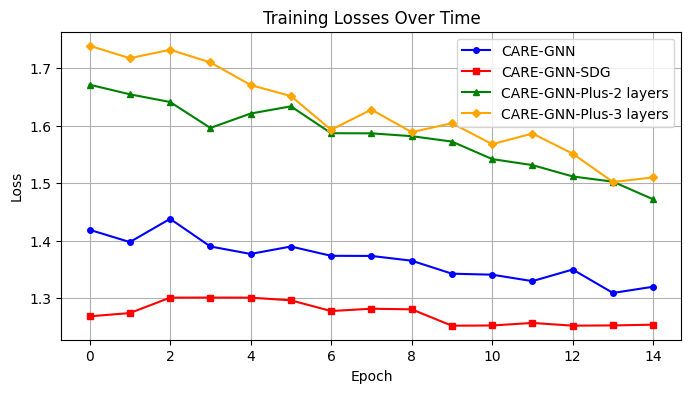

In [54]:
import matplotlib.pyplot as plt

# Plot the dataframe with specified figure size
plt.figure(figsize=(8, 4))

# Define colors and markers for each column
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

# Plot each column with different color and marker
for i, column in enumerate(df_train_losses.columns):
    plt.plot(df_train_losses[column],
             color=colors[i % len(colors)],
             marker=markers[i % len(markers)],
             label=column,
             markersize=4,
             linewidth=1.5)

# Add labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Over Time")

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [55]:
df_auc_recall = pd.DataFrame({
    'Model': ['CARE-GNN', 'CARE-GNN-SDG', 'CARE-GNN-Plus-2 layers', 'CARE-GNN-Plus-3 layers'],
    'AUC': [gnn_auc, gnn_auc_base, gnn_auc_2l, gnn_auc_3l],
    'Recall': [gnn_recall, gnn_recall_base, gnn_recall_2l, gnn_recall_3l]
})




In [56]:
df_auc_recall

,Model,AUC,Recall
0,CARE-GNN,0.943105,0.889906
1,CARE-GNN-SDG,0.942574,0.890777
2,CARE-GNN-Plus-2 layers,0.878689,0.881604
3,CARE-GNN-Plus-3 layers,0.917675,0.882165


<Figure size 1200x600 with 0 Axes>

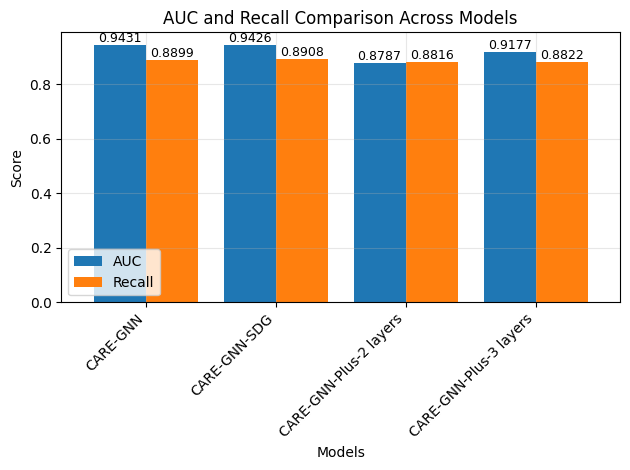

In [66]:
#import matplotlib.pyplot as plt

# Set the model names as index for easier plotting
df_plot = df_auc_recall.set_index('Model')

# Create bar plot with custom colors (flat list)
plt.figure(figsize=(12, 6))
ax1 = df_plot.plot(kind='bar', width=0.8,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])

# Add value labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.4f', fontsize=9, rotation=0)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('AUC and Recall Comparison Across Models')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()